# Project 4: West Nile Virus Analysis

## Part 2 - Modelling and Evaluation

In this notebook we will build the classification models to predict the presence of West Nile Virus in a trap on a given date. The data imported here is cleaned in Part I of this project. The virus only spreads to humans through mosquitoes and thus looking at the distribution of mosquito population across city, should be a good predictor of virus. Mosquito growth rates can vary with weather factors like $-$ temperature, precipitation. The mosquito life cycle changes with this seasonal changes and we should be able to use this data to predict the presence of virus. Location in the city is also a relevant feature that can have large impact on our modelling results.

**Modelling**

This is a binary classification problem where we predict if the West Nile Virus is detected (positive class) in an observation or not (negative class). These models that predict highly unbalanced classes can suffer from underfit on the minority class and metrics can be really worse depending on the output goal. One of the techniques used in this project is SMOTE. It is short for _Synthetic Minority Oversampling Technique_, which means we oversample the minority class (for training data) so that the two output classes are balanced.

Training with this newly balanced class dataset does come with its own caveats, e.g., the synthetic data generated is not representative of the real-world scenario where mostly the class distribution would be uneven, and this can lead to overfitting the model on the minority class. Then when we fit the validation/test data, our model might not perform as well. However, benefits of using the oversampling technique outweighs using not using it, as shown later.

We start with Logistic Regression, which is a commonly used classification model, and than try a bunch of tree based models, like, Extra Trees, Random Forests, and boosting, like AdaBoost, XGBoost. For a classification problem of this type and distribution, where we have many seemingly correlated features, decision trees can be a great way to classify them. Although, on there own, there is a very high probablity of them overfitting and thus we use other techniques such as bootstrapping along with ensemble methods like bagging classifier to overcome this issue.


#### Contents

The contents of this notebook are as follows:
- [Imports](#Imports)

- [Modelling](#Modelling)

- [Evaluation](#Evaluation)

- [Recommendations and Conclusion](#Recommendations-and-Conclusion)

## Imports

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import time
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

# from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline, make_pipeline

#from joblib import dump, load

In [2]:
# Function to save kaggle submissions for WnvPresent probabilities
def get_kaggle_format(prediction_probs):
    # load the sample submission file
    sub = pd.read_csv('../datasets/sampleSubmission.csv')
    sub['WnvPresent'] = prediction_probs
    
    # Output filename for kaggle submission
    i = 0
    while os.path.exists(f"../datasets/kaggle_sub_{i}.csv"):
        i += 1
    filename = f"../datasets/kaggle_sub_{i}.csv"
    
    # Save the DataFrame to a file
    sub.to_csv(filename, index=False)
    print(f'File name: {filename}')

In [3]:
# import data
pd.set_option('display.max_columns', None)
train = pd.read_csv('../datasets/combined_cleaned.csv')
test = pd.read_csv('../datasets/test_cleaned.csv')

In [4]:
train.head()

,date,latitude,longitude,wnv_present,species_label_1.0,species_label_2.0,species_label_3.0,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,sunrise,sunset,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed,daylight,r_humid,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc,tavg_10,tavg_14,tavg_28,precip_total_10,precip_total_14,precip_total_28,r_humid_10,r_humid_14,r_humid_28,week
0,2007-05-29,41.731922,-87.677512,0,0,0,1,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,261.0,1157.0,0.0,29.415,30.1,5.8,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,67.25,64.678571,63.714286,0.08575,0.06875,0.055,196.319405,208.835422,207.239818,22
1,2007-05-29,41.954690,-87.800991,0,0,1,0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,261.0,1157.0,0.0,29.415,30.1,5.8,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,67.25,64.678571,63.714286,0.08575,0.06875,0.055,196.319405,208.835422,207.239818,22
2,2007-05-29,41.974089,-87.824812,0,0,1,0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,261.0,1157.0,0.0,29.415,30.1,5.8,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,67.25,64.678571,63.714286,0.08575,0.06875,0.055,196.319405,208.835422,207.239818,22
3,2007-05-29,41.867108,-87.654224,0,0,1,0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,261.0,1157.0,0.0,29.415,30.1,5.8,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,67.25,64.678571,63.714286,0.08575,0.06875,0.055,196.319405,208.835422,207.239818,22
4,2007-05-29,41.919343,-87.694259,0,0,1,0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,261.0,1157.0,0.0,29.415,30.1,5.8,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,67.25,64.678571,63.714286,0.08575,0.06875,0.055,196.319405,208.835422,207.239818,22


In [5]:
test.head()

,date,latitude,longitude,species_label_1.0,species_label_2.0,species_label_3.0,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,sunrise,sunset,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed,daylight,r_humid,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc,tavg_10,tavg_14,tavg_28,precip_total_10,precip_total_14,precip_total_28,r_humid_10,r_humid_14,r_humid_28,week
0,2008-06-11,41.95469,-87.800991,0,1,0,86.0,63.5,75.0,6.0,55.5,64.0,0.0,10.0,256.0,1166.0,0.0,29.31,29.98,9.15,18.0,10.2,910.0,197.412262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72.7,70.25,62.678571,0.273,0.223214,0.127411,146.781616,153.471845,166.266846,24
1,2008-06-11,41.95469,-87.800991,1,0,0,86.0,63.5,75.0,6.0,55.5,64.0,0.0,10.0,256.0,1166.0,0.0,29.31,29.98,9.15,18.0,10.2,910.0,197.412262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72.7,70.25,62.678571,0.273,0.223214,0.127411,146.781616,153.471845,166.266846,24
2,2008-06-11,41.95469,-87.800991,0,0,1,86.0,63.5,75.0,6.0,55.5,64.0,0.0,10.0,256.0,1166.0,0.0,29.31,29.98,9.15,18.0,10.2,910.0,197.412262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72.7,70.25,62.678571,0.273,0.223214,0.127411,146.781616,153.471845,166.266846,24
3,2008-06-11,41.95469,-87.800991,0,0,0,86.0,63.5,75.0,6.0,55.5,64.0,0.0,10.0,256.0,1166.0,0.0,29.31,29.98,9.15,18.0,10.2,910.0,197.412262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72.7,70.25,62.678571,0.273,0.223214,0.127411,146.781616,153.471845,166.266846,24
4,2008-06-11,41.95469,-87.800991,0,0,0,86.0,63.5,75.0,6.0,55.5,64.0,0.0,10.0,256.0,1166.0,0.0,29.31,29.98,9.15,18.0,10.2,910.0,197.412262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72.7,70.25,62.678571,0.273,0.223214,0.127411,146.781616,153.471845,166.266846,24


In [6]:
# check dtypes
train.dtypes

date                  object
latitude             float64
longitude            float64
wnv_present            int64
species_label_1.0      int64
species_label_2.0      int64
species_label_3.0      int64
tmax                 float64
tmin                 float64
tavg                 float64
depart               float64
dew_point            float64
wet_bulb             float64
heat                 float64
cool                 float64
sunrise              float64
sunset               float64
precip_total         float64
stn_pressure         float64
sea_level            float64
result_speed         float64
result_dir           float64
avg_speed            float64
daylight             float64
r_humid              float64
bc                     int64
br                     int64
dz                     int64
fg                     int64
fg+                    int64
fu                     int64
gr                     int64
hz                     int64
mi                     int64
ra            

In [7]:
# Get the training features and target variable
X = train.drop(columns=['date', 'wnv_present',])
y = train['wnv_present']

# Get the test dataset features
test = test.drop(columns=['date'])

In [8]:
# split the data into train and val for basic model building
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=42, shuffle=False)

#### Baseline accuracy

In [9]:
# target distribution
y_train.value_counts(normalize=True)

0    0.960502
1    0.039498
Name: wnv_present, dtype: float64

As discussed in the EDA part that the classes are highly unbalanced and we will employ the SMOTE technique to make the two classes of same distribution. This avoids overtraining the model on one class and makes better predictions.

## Modelling

Now we can build the models and train them using the training data. Since this is a classification problem of predicting whether a particular trap would have mosquitos with west nile virus or not, we will try some of them and run `GridSearchCV` to see which one gives us best results. Later, we will evaluate and discuss various metrics for the different models by interpreting the results.

### Pipelines

It is convenient to create pipelines using the `imblearns`'s `Pipeline` method, which is very similar to `sklearn's`, but we use this since we are using SMOTE. We can also write a function to get the results and print evaluations, so it is easier to consolidate everything when we run grid-search at once.

In [10]:
#dictionary for pipeline
pipes_dict = {
    'pipe_lr': Pipeline([
        ('smote', SMOTENC([31, 32, 33, 34], random_state=42)),
        ('sc', StandardScaler()),
        ('lr', LogisticRegression(random_state=42))
    ]),
    'pipe_dt': Pipeline([
        ('smote', SMOTENC([31, 32, 33, 34], random_state=42)),
        ('sc', StandardScaler()),
        ('dt', DecisionTreeClassifier(random_state=42))
    ]),
    'pipe_et': Pipeline([
        ('smote', SMOTENC([31, 32, 33, 34], random_state=42)),
        ('sc', StandardScaler()),
        ('et', ExtraTreesClassifier(random_state=42))
    ]),
    'pipe_rf': Pipeline([
        ('smote', SMOTENC([31, 32, 33, 34], random_state=42)),
        ('sc', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=42))
    ]),
    'pipe_bc': Pipeline([
        ('smote', SMOTENC([31, 32, 33, 34], random_state=42)),
        ('sc', StandardScaler()),
        ('bc', BaggingClassifier(random_state=42))
    ]),
    'pipe_ab': Pipeline([
        ('smote', SMOTENC([31, 32, 33, 34], random_state=42)),
        ('sc', StandardScaler()),
        ('ab', AdaBoostClassifier(random_state=42))
    ]),
    'pipe_xgb': Pipeline([
        ('smote', SMOTENC([31, 32, 33, 34], random_state=42)),
        ('sc', StandardScaler()),
        ('xgb', XGBClassifier())
    ])
}

In [11]:
#dictionary for pipeline parameters
pipe_params = {
    'pipe_lr_params': {
        'lr__penalty' : ['l2'],
        'lr__C' : [0.001, 0.1, 10], #0.0001,0.001,0.01,0.1,1,10,20
        'lr__max_iter' : [1000] 
    },
    'pipe_dt_params': {
        'dt__max_depth': [2], #2,4,10
        'dt__min_samples_split': [2], #2,5,10,15
        'dt__min_samples_leaf': [2], #2,4,6
        'dt__ccp_alpha': [0] #0,0.01,1
    },
    'pipe_et_params': {
        'et__n_estimators': [50, 100, 200],
        'et__max_depth': [2, 3, 5, 10, 20],
        'et__min_samples_leaf': [2, 5, 10],
        'et__class_weight' : ['balanced', 'balanced_subsample']
    },
    'pipe_rf_params': {
        'rf__max_depth': [1, 2, 5],
        'rf__max_features': ['sqrt', 'log2'],
        'rf__min_samples_leaf': [2, 5],
        'rf__n_estimators': [50, 100, 500],
         'rf__warm_start': [True, False]
    },
    'pipe_bc_params': {
        'bc__bootstrap_features': [True, False],
        'bc__n_estimators': [100, 500, 1000],
        'bc__max_features': [0.1, 0.5, 1.0]
    },
    'pipe_ab_params': {
        'ab__learning_rate': [0.1, 0.5, 0.9], #0.7,0.8,0.9,1
        'ab__n_estimators': [25, 50, 100],  #20,25,50,100,200,300
    },
    'pipe_xgb_params': {
        'xgb__n_estimators': [50, 75, 100],
        'xgb__max_depth': [2, 3, 5],
         'xgb__gamma' : [0.1, 0.5, 1], 
        'xgb__learning_rate' : [0.1, 0.2, 0.5],
        'xgb__eval_metric': ['auc']
    }
}

#### Function for modelling

In [12]:
#function for model
#list to store results and evaluation metrics for models
model_results = []

#store the models and params from gridsearch to dict
gs_dict = {}

#function to train model and store results in model_results list
def model_eval(pipeline, params):
    # get the name of the grid search model
    model = pipeline.steps[2][0]   #model name

    gs = f'gs_{model}'
    
    # instantiate the grid search
    gs_dict[gs] = GridSearchCV(estimator=pipeline,
                               param_grid=params,
                               scoring='roc_auc',
                               verbose=1,
                               n_jobs=-1)
    
    
    gs_dict[gs].fit(X_train, y_train)  #fit our model onto gridsearchCV
        
    results = {}  #initialise results dictionary
    
    results['Classifier'] = model
    
    # train prediction probas
    y_train_pred = gs_dict[gs].predict(X_train)
    y_train_pred_probas = gs_dict[gs].predict_proba(X_train)[:,1]
    
    # validation predictions    
    y_val_pred = gs_dict[gs].predict(X_val) #get the predictions
    y_val_pred_probas = gs_dict[gs].predict_proba(X_val)[:, 1]
    
    results['Train Acc Score'] = accuracy_score(y_train, y_train_pred) #train accuracy score
    results['Val Acc Score'] = accuracy_score(y_val, y_val_pred) #val accuracy score
    
    results['Train ROC-AUC'] = roc_auc_score(y_train, y_train_pred_probas) #train roc-auc score
    results['Val ROC-AUC'] = roc_auc_score(y_val, y_val_pred_probas) #val roc-auc score
    
    results['Recall'] = recall_score(y_val, y_val_pred)  #recall score
    results['Precision'] = precision_score(y_val, y_val_pred)  #precision score
    results['F1-Score'] = f1_score(y_val, y_val_pred) #f1-score
    
    model_results.append(results) #append dictionary into model_results list
    
    return gs_dict[gs].best_estimator_, gs_dict[gs].best_params_

### Generating Models

Now, we can run each model pipeline through the grid search and later we can evaluate the results.

In [13]:
start = time.time()

#### Logistic Regression

In [14]:
model_eval(pipeline=pipes_dict['pipe_lr'], params=pipe_params['pipe_lr_params'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


(Pipeline(steps=[('smote',
                  SMOTENC(categorical_features=[31, 32, 33, 34],
                          random_state=42)),
                 ('sc', StandardScaler()),
                 ('lr',
                  LogisticRegression(C=0.001, max_iter=1000, random_state=42))]),
 {'lr__C': 0.001, 'lr__max_iter': 1000, 'lr__penalty': 'l2'})

#### Decision Trees

In [15]:
model_eval(pipeline=pipes_dict['pipe_dt'], params=pipe_params['pipe_dt_params'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


(Pipeline(steps=[('smote',
                  SMOTENC(categorical_features=[31, 32, 33, 34],
                          random_state=42)),
                 ('sc', StandardScaler()),
                 ('dt',
                  DecisionTreeClassifier(ccp_alpha=0, max_depth=2,
                                         min_samples_leaf=2, random_state=42))]),
 {'dt__ccp_alpha': 0,
  'dt__max_depth': 2,
  'dt__min_samples_leaf': 2,
  'dt__min_samples_split': 2})

#### Extra Trees

In [16]:
model_eval(pipeline=pipes_dict['pipe_et'], params=pipe_params['pipe_et_params'])

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(Pipeline(steps=[('smote',
                  SMOTENC(categorical_features=[31, 32, 33, 34],
                          random_state=42)),
                 ('sc', StandardScaler()),
                 ('et',
                  ExtraTreesClassifier(class_weight='balanced', max_depth=2,
                                       min_samples_leaf=2, n_estimators=50,
                                       random_state=42))]),
 {'et__class_weight': 'balanced',
  'et__max_depth': 2,
  'et__min_samples_leaf': 2,
  'et__n_estimators': 50})

#### Random Forest

In [17]:
model_eval(pipeline=pipes_dict['pipe_rf'], params=pipe_params['pipe_rf_params'])

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(Pipeline(steps=[('smote',
                  SMOTENC(categorical_features=[31, 32, 33, 34],
                          random_state=42)),
                 ('sc', StandardScaler()),
                 ('rf',
                  RandomForestClassifier(max_depth=1, max_features='log2',
                                         min_samples_leaf=2, n_estimators=500,
                                         random_state=42, warm_start=True))]),
 {'rf__max_depth': 1,
  'rf__max_features': 'log2',
  'rf__min_samples_leaf': 2,
  'rf__n_estimators': 500,
  'rf__warm_start': True})

#### Bagging Classifier

In [18]:
model_eval(pipeline=pipes_dict['pipe_bc'], params=pipe_params['pipe_bc_params'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(Pipeline(steps=[('smote',
                  SMOTENC(categorical_features=[31, 32, 33, 34],
                          random_state=42)),
                 ('sc', StandardScaler()),
                 ('bc',
                  BaggingClassifier(bootstrap_features=True, max_features=0.1,
                                    n_estimators=100, random_state=42))]),
 {'bc__bootstrap_features': True,
  'bc__max_features': 0.1,
  'bc__n_estimators': 100})

#### AdaBoost Classifier

In [19]:
model_eval(pipeline=pipes_dict['pipe_ab'], params=pipe_params['pipe_ab_params'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(Pipeline(steps=[('smote',
                  SMOTENC(categorical_features=[31, 32, 33, 34],
                          random_state=42)),
                 ('sc', StandardScaler()),
                 ('ab',
                  AdaBoostClassifier(learning_rate=0.1, n_estimators=25,
                                     random_state=42))]),
 {'ab__learning_rate': 0.1, 'ab__n_estimators': 25})

#### XGBoost Classifier

In [20]:
model_eval(pipeline=pipes_dict['pipe_xgb'], params=pipe_params['pipe_xgb_params'])

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


(Pipeline(steps=[('smote',
                  SMOTENC(categorical_features=[31, 32, 33, 34],
                          random_state=42)),
                 ('sc', StandardScaler()),
                 ('xgb',
                  XGBClassifier(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, eval_metric='auc', gamma=0.1,
                                gpu_id=-1, importance_type='gain',
                                interaction_constraints='', learning_rate=0.1,
                                max_delta_step=0, max_depth=2,
                                min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estimators=50,
                                n_jobs=8, num_parallel_tree=1, random_state=0,
                                reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                subsample=1, tree_method='exact',


In [21]:
print(f"It took {time.time() - start} secs to run grid search.")

It took 537.2356491088867 secs to run grid search.


## Model Evaluation

Based on the grid searching on models above, we will summarize the results here and select the best performing model to predict the final test dataset.

In [22]:
# results dataframe
model_performance = pd.DataFrame(model_results).sort_values(by='Val ROC-AUC', ascending = False)
model_performance.reset_index(drop=True)

,Classifier,Train Acc Score,Val Acc Score,Train ROC-AUC,Val ROC-AUC,Recall,Precision,F1-Score
0,xgb,0.741312,0.792803,0.882247,0.729746,0.408072,0.188406,0.257790
1,et,0.710290,0.865164,0.848968,0.721504,0.147982,0.179348,0.162162
2,ab,0.708256,0.779359,0.848738,0.706233,0.295964,0.141328,0.191304
3,bc,0.798779,0.429419,0.916910,0.692877,0.905830,0.124384,0.218733
4,lr,0.746228,0.783709,0.842807,0.687969,0.336323,0.158228,0.215208
5,rf,0.676894,0.850534,0.845842,0.680681,0.152466,0.152466,0.152466
6,dt,0.787930,0.827204,0.811114,0.623974,0.233184,0.163522,0.192237


The _XGBoost Classifier_ model performed the best with , based on the accuracy score, with 0.977 on train and 0.897 on validation. Although, this shows a bit of overfitting on train data, we can tune it to get better results. However, as mentioned in the intro, accuracy is not the best metric for these, and so we look at the ROC-AUC.

The above dataframe is sorted by `Val ROC-AUC`, and it shows that the _AdaBoost Classifier_ model performed the best on the validation dataset. The ROC-AUC curve is a balance between recall and precision. For us, we want to predict as many observations with virus correctly but also want to minimize misclassifying the actual observations with virus, so recall is the metric we can look at. This helps us reduce the false negatives, and thus we can choose the __AdaBoost Classifier__ as our best model.

In [23]:
# best model
best_model = gs_dict[f'gs_{model_performance.iloc[0,0]}']
best_model

GridSearchCV(estimator=Pipeline(steps=[('smote',
                                        SMOTENC(categorical_features=[31, 32,
                                                                      33, 34],
                                                random_state=42)),
                                       ('sc', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
   

The best model as we can see above is the _AdaBoost Classifier_ with SMOTE oversampled trained data and learning rate of **xx** and number of estimators **xx**. Let's further evaluate this model to see its properties.

In [24]:
# write a function to plot the confusion matrix and ROC curve
def plot_cm_roc(model, X, y):
    roc_train = roc_auc_score(y_true=y_train, y_score=model.predict_proba(X_train)[:,1])
    roc_test = roc_auc_score(y_true=y, y_score=model.predict_proba(X)[:,1])
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
    ax[0].set_title("Confusion Matrix for test data")
    ax[1].set_title("ROC AUC curve")
    plot_confusion_matrix(estimator=model,
                          X=X,
                          y_true=y,
                          cmap='Blues',
                          values_format='d',
                          colorbar=False,
                          ax=ax[0])
    plot_roc_curve(estimator=model, X=X_train, y=y_train, ax=ax[1])
    plot_roc_curve(estimator=model, X=X, y=y, ax=ax[1])
    ax[1].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--')
    ax[1].legend([f'train (AUC = {round(roc_train, 2)})',
                  f'valid  (AUC = {round(roc_test, 2)})',
                  'baseline (AUC = 0.5)']);

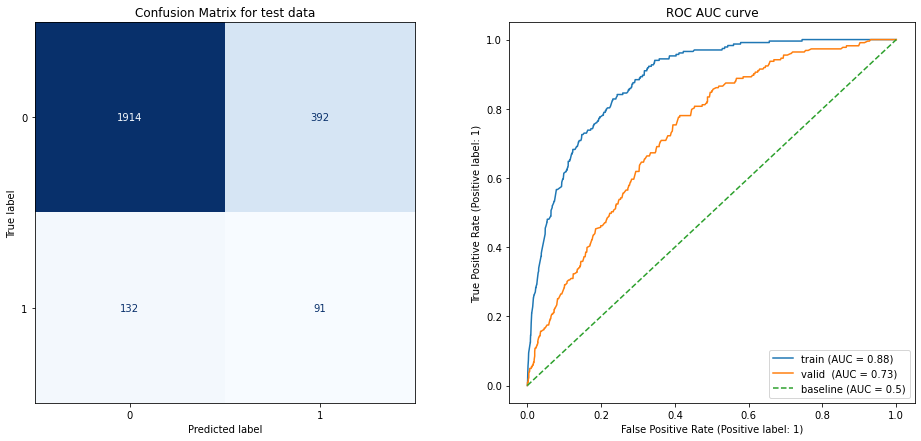

In [25]:
# plot the confusion matrix and ROC-AUC curve
plot_cm_roc(best_model, X_val, y_val)

In [26]:
# target distribution for validation data
y_val.value_counts()

0    2306
1     223
Name: wnv_present, dtype: int64

In [27]:
# recall
recall_score(y_val, best_model.predict(X_val))

0.4080717488789238

The above two plots summarizes the best model performance really well. On the left is the confusion matrix, laying out the true negatives, false negatives, false positives, and true positives. Given the imbalance in the target variable for the validation data is almost 10:1, our model still predicted more than 50% of the positive class correctly. However, the false negatives are also quite high, at 527 about 25% were misclassified as being postive class, i.e. the virus was found when it is not. The reason for this is because of the oversampling of the minority class, which overtrains our model on the minority class.

On the right is the ROC-AUC score, which shows how well our model separates the two classes with 0.5 being the baseline. As we can see the training score is 0.88, which is quite high compared to the validation score of 0.74. The tuning of hyper-parameters in the grid search can help us reduce this gap further. Selecting adequate features and using feature interactions could also assist in improving the score. On that note, let's look at some of the features importances of the models.

### Feature importances

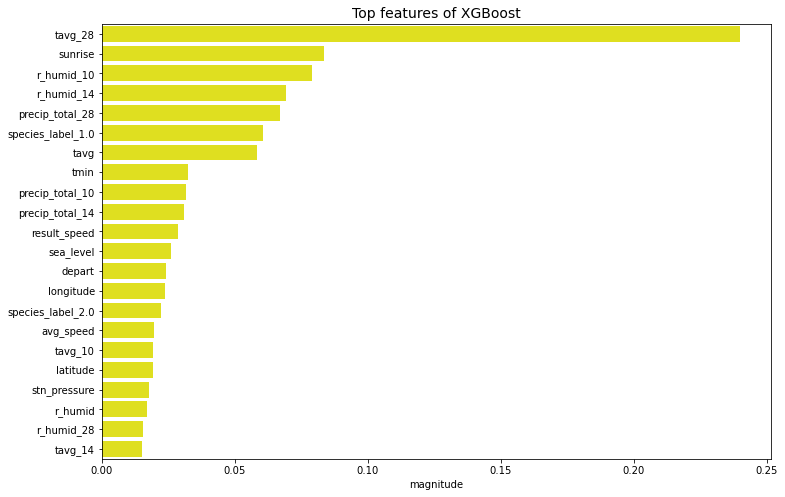

In [28]:
# Feature importances xgboost
importance = pd.DataFrame(best_model.best_estimator_.named_steps['xgb'].feature_importances_,
                          index=X_train.columns).sort_values(by=0, ascending=False)
importance = importance[importance > 0].dropna().rename(columns={0: 'magnitude'})

# plot the importance values > 0
plt.figure(figsize=(12, 8))
plt.title("Top features of XGBoost", fontdict={'fontsize': 14})
sns.barplot(data=importance, x='magnitude', y=importance.index, color='yellow');

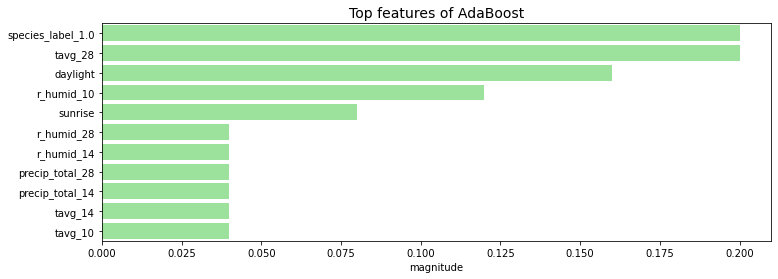

In [29]:
# Feature importances adaboost
importance = pd.DataFrame(gs_dict['gs_ab'].best_estimator_.named_steps['ab'].feature_importances_,
                          index=X_train.columns).sort_values(by=0, ascending=False)
importance = importance[importance > 0].dropna().rename(columns={0: 'magnitude'})

# plot the importance values > 0
plt.figure(figsize=(12, 4))
plt.title("Top features of AdaBoost", fontdict={'fontsize': 14})
sns.barplot(data=importance, x='magnitude', y=importance.index, color='lightgreen');

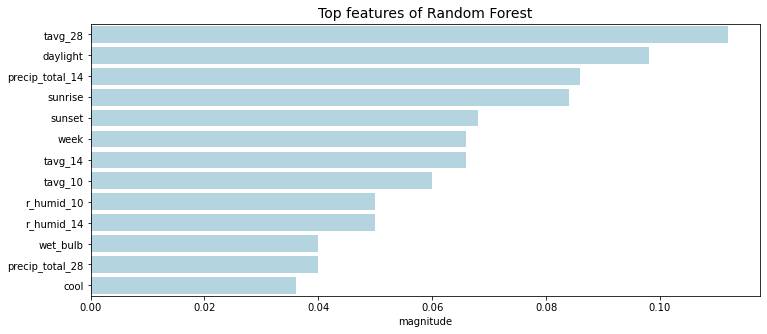

In [30]:
# Feature importances random forest
importance = pd.DataFrame(gs_dict['gs_rf'].best_estimator_.named_steps['rf'].feature_importances_,
                          index=X_train.columns).sort_values(by=0, ascending=False)
importance = importance[importance > 0.02].dropna().rename(columns={0: 'magnitude'})

# plot the importance values > 0
plt.figure(figsize=(12, 5))
plt.title("Top features of Random Forest", fontdict={'fontsize': 14})
sns.barplot(data=importance, x='magnitude', y=importance.index, color='lightblue');

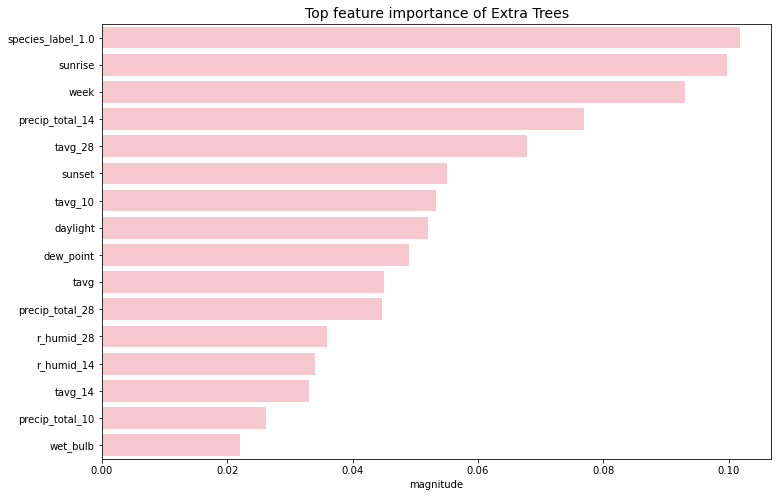

In [31]:
# Feature importances extra trees
importance = pd.DataFrame(gs_dict['gs_et'].best_estimator_.named_steps['et'].feature_importances_,
                          index=X_train.columns).sort_values(by=0, ascending=False)
importance = importance[importance > 0.02].dropna().rename(columns={0: 'magnitude'})

# plot the importance values > 0
plt.figure(figsize=(12, 8))
plt.title("Top feature importance of Extra Trees", fontdict={'fontsize': 14})
sns.barplot(data=importance, x='magnitude', y=importance.index, color='pink');

### Kaggle

In [32]:
best_model

GridSearchCV(estimator=Pipeline(steps=[('smote',
                                        SMOTENC(categorical_features=[31, 32,
                                                                      33, 34],
                                                random_state=42)),
                                       ('sc', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
   

In [33]:
#fit the best model with entire training data to make predictions for the test
best_model.best_estimator_.fit(X, y)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=[31, 32, 33, 34],
                         random_state=42)),
                ('sc', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='auc', gamma=0.1,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                

In [34]:
#save the kaggle submission file
get_kaggle_format(best_model.predict_proba(test)[:, 1])

File name: ../datasets/kaggle_sub_4.csv


#### Kaggle Submission

## Cost Benefit Analysis

West Nile Virus first emerged in the New York(US) metropolitan area in the fall of 1999.

As of July 23rd, 34 states have reported West Nile virus infections in people, birds, or mosquitoes in 2019.
In 2018, 49 out of 50 states and the District of Columbia reported West Nile virus infections in people, birds, or mosquitoes. Overall, 2,647 cases of WNV were reported in humans, and there were 167 (6.3%) confirmed deaths in 2018. 
This shows an increase from the number of human cases reported in 2017 (2,097). It also brings attention to the increase in lives lost, when compared to the 146 (7%) confirmed deaths in 2017 and the 106 (4.9%) confirmed deaths from WNV in 2016.

#### Symptoms of West Nile Virus
- The majority (4 out of 5) of people infected with West Nile virus will experience no symptoms.
- Approximately 20% of people affected by the virus will experience flu-like symptoms including fever, headache, nausea, muscle pain, and swollen lymph glands.
- Other symptoms may include a stiff neck, rash, sleepiness or disorientation.
- Less than 1% of those infected will develop West Nile Encephalitis or Meningitis, which can lead to coma, tremors, convulsions, paralysis, and even death.

Hence, it is vital to prevent the spread of mosquitoes

#### Types of patients with West Nile Virus
- West Nile fever (WNF): causing flu-like symptoms, mild compared to WNND
- West Nile neuroinvasive disease (WNND): severe, affecting central nervous system symptom

#### Total economic cost
We will use reference of West Nile Virus economic impact from [this site].(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/)

According to 2005 Sacramento County WNV epidemic, there are 117 WNF and 46 WNND cases, totaling to 163 cases. The total spray area was 477 km². A summary estimate of the economic cost can be found below:

#image

It showed that for WNND cases, the cost ratio of medical, productivity and miscellaneous cost is 3 times more than the cost of spraying. A spray event would only need to stop 15 WNND cases for the benefits of spraying to outweigh the epidemic cost.

The number of cases that were saved because of spraying were uncertain, but Carney et al. and Elnaiem et al. provided evidence showing the effectiveness of the 2005 emergency aerial spray as a mosquito control by showing a reduction both in mosquito populations and WNV disease cases in humans. In a study, there were no cases within the spray area, but with 18 cases outside the area. This shows that spray do help and is necessary in managing the WNV. 

The analysis showed that the 

Considering the population and area of Sacramento, we will extend the cost to Chicago.
The average number of WNV present in the traps for train dataset is 138. Assuming each trap with WNV present could spread to 2-3 people, we would do a cost benefit analysis on 325 WNV cases and 112.3km² of spray area in Chicago.

For benefits of spraying to outweigh the epidemic cost, a spray event would need to stop 12 WNV cases.

The Annual Cost Projection is shown below for test set:

For spraying benefit to outweigh the cost of being ill from WNV, we should spray in areas with more than 12 WNV cases.
There are currently no WNV vaccine available. Hence, spraying is still beneficial. Spraying larvicides kills mosquito larvae that hatch from eggs, spraying adulticides quickly kills flying mosquitoes. Both larvicides and adulticides temporarily reduce the number of mosquitoes in an area, but do not permanently get rid of them. Hence, people should still play their part in preventing mosquitoes from breeding.

*Estimating the medical costs of WNV patients and the true number of cases prevented by the emergency spray are uncertain.

The spraying benefits for Chicago outweighs Sacramento County as it is more densely populated. Hence, a spray event would save more people.

## Conclusion and Recommendations

Conclusion:

Our model is successful in predicting the west nile virus to a great extent. However, there are many setbacks we have to consider. 

Firstly, majority of our best features are weather features which are also the ones we cannot control. 




Recommendations:

There is no vaccine if one is affected with the virus. Hence, we have to look into preventive measures to avoid getting the virus in the first place.

General Measures:

Individual:


Community:

    - Example of how we do it in singapore 

# References 

https://www.tazewellhealth.org/228/History-of-West-Nile-Virus

https://www.vdci.net/vector-borne-diseases/west-nile-virus-education-and-mosquito-management-to-protect-public-health/

https://www.sciencedaily.com/releases/2014/02/140210184713.htm

https://www.npr.org/sections/health-shots/2014/02/11/275262857/the-high-cost-of-treating-people-hospitalized-with-west-nile-virus

https://www.chicago.gov/city/en/depts/cdph/supp_info/infectious/west_nile_virus_surveillancereports.html

https://www.cdc.gov/westnile/vectorcontrol/aerial-spraying.html

https://www.medicinenet.com/script/main/art.asp?articlekey=176668

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/

https://www.in2013dollars.com/Chicago-Illinois/price-inflation